In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
from torch import nn, tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms, ToTensor
import torchvision.utils as vutils


LATENT = 32
DIMS_E = [16, 32, 64, 32]
DIMS_G = [32, 64, 32, 16]
DIMS_D = [16, 32, 64, 32]
MODEL_E_PATH = "ffhq-64x64-e.pth"
MODEL_G_PATH = "ffhq-64x64-g.pth"
MODEL_D_PATH = "ffhq-64x64-d.pth"
EXPORT_PATH = "raw-weights-ffhq-64x64"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:

class FFHQDataset(Dataset):

    def __init__(self, transform=None, target_transform=None):
        self.size = 64
        self.path = f"../data/FFHQ/{self.size}x{self.size}/"
        self.raw_bytes = {}
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        #return 10000
        return 70000

    def __getitem__(self, i):
        bd = i - i % 1000
        filepath = self.path + "{:05d}.raw".format(bd)
        if filepath not in self.raw_bytes:
            content = np.fromfile(filepath, dtype=np.uint8)
            content = content.reshape((1000, 3, self.size, self.size))
            self.raw_bytes[filepath] = content
        else:
            content = self.raw_bytes[filepath]
        return content[i%1000].astype(np.float32) / 255.0


def load_data(dataset, plot=False):
    dataloader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=True
    )
    for x in dataloader:
        print("Shape of x:", x.shape)
        break
    if plot:
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(
            next(iter(dataloader)).to(device)[:64],
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                   interpolation='nearest')
        plt.show()
    return dataloader


In [38]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        dims = DIMS_E
        self.main = nn.Sequential(
            # 3 x 64x64
            nn.Conv2d(3, dims[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[0]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[0] x 32x32
            nn.Conv2d(dims[0], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[1] x 16x16
            nn.Conv2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[2] x 8x8
            nn.Conv2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[3] x 4x4
            nn.Conv2d(dims[3], LATENT, 4, 1, 0, bias=False),
            nn.Flatten()
        )

    def forward(self, x):
        return self.main(x)


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        # ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        dims = DIMS_G
        layers = [
            # LATENT
            nn.Linear(LATENT, dims[0]*4*4, bias=False),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Unflatten(1, (dims[0], 4, 4)),
            # dims[0] x 4x4
            nn.ConvTranspose2d(dims[0], dims[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[0]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(dims[0], dims[1], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[1] x 8x8
            nn.ConvTranspose2d(dims[1], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(dims[1], dims[1], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(dims[1], dims[2], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[2] x 16x16
            nn.ConvTranspose2d(dims[2], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(dims[2], dims[2], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(dims[2], dims[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[3] x 32x32
            nn.ConvTranspose2d(dims[3], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(dims[3], dims[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(dims[3], 3, 3, 1, 1, bias=False),
            nn.Sigmoid()
            # 3 x 64x64
        ]
        layers = [layer for layer in layers if layer is not None]
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        dims = DIMS_D
        self.main = nn.Sequential(
            # (3+3) x 64x64
            nn.Conv2d(6, dims[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[0]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[0] x 32x32
            nn.Conv2d(dims[0], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[1] x 16x16
            nn.Conv2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[2] x 8x8
            nn.Conv2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[3] x 4x4
            nn.Conv2d(dims[3], 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


Shape of x: torch.Size([64, 3, 64, 64])
Encoder 91168
Encoder(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True

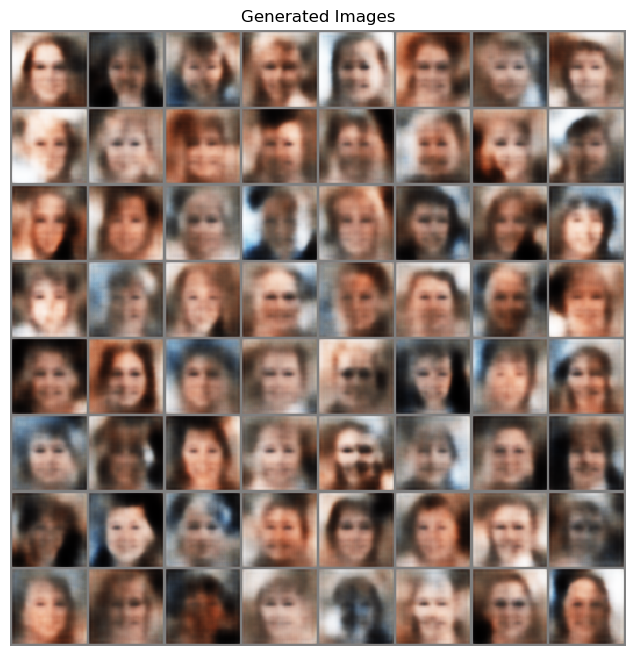

Epoch 2
[100/1094]  loss_diff=0.2735 loss_ediff=0.0138 loss_vae=0.0679 loss_d=0.0008 loss_d_eg=0.0264 loss=0.3816
[200/1094]  loss_diff=0.2660 loss_ediff=0.0144 loss_vae=0.0641 loss_d=0.0007 loss_d_eg=0.0278 loss=0.3724
[300/1094]  loss_diff=0.2775 loss_ediff=0.0147 loss_vae=0.0561 loss_d=0.0006 loss_d_eg=0.0293 loss=0.3776
[400/1094]  loss_diff=0.2673 loss_ediff=0.0150 loss_vae=0.0573 loss_d=0.0005 loss_d_eg=0.0312 loss=0.3708
[500/1094]  loss_diff=0.2605 loss_ediff=0.0144 loss_vae=0.0576 loss_d=0.0005 loss_d_eg=0.0322 loss=0.3646
[600/1094]  loss_diff=0.2681 loss_ediff=0.0139 loss_vae=0.0573 loss_d=0.0003 loss_d_eg=0.0349 loss=0.3742
[700/1094]  loss_diff=0.2673 loss_ediff=0.0138 loss_vae=0.0624 loss_d=0.0004 loss_d_eg=0.0352 loss=0.3787
[800/1094]  loss_diff=0.2686 loss_ediff=0.0141 loss_vae=0.0614 loss_d=0.0002 loss_d_eg=0.0378 loss=0.3819
[900/1094]  loss_diff=0.2666 loss_ediff=0.0142 loss_vae=0.0543 loss_d=0.0003 loss_d_eg=0.0384 loss=0.3736
[1000/1094]  loss_diff=0.2683 loss_edi

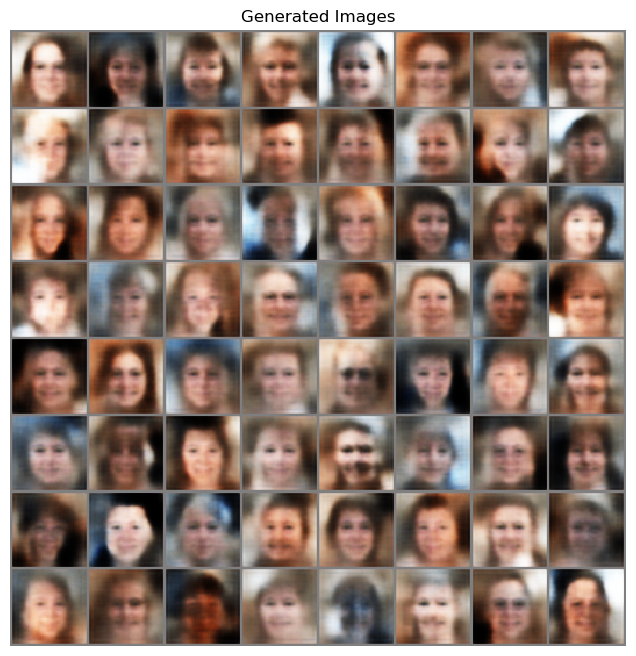

Epoch 3
[100/1094]  loss_diff=0.2763 loss_ediff=0.0138 loss_vae=0.0582 loss_d=0.0002 loss_d_eg=0.0424 loss=0.3907
[200/1094]  loss_diff=0.2628 loss_ediff=0.0127 loss_vae=0.0519 loss_d=0.0001 loss_d_eg=0.0448 loss=0.3721
[300/1094]  loss_diff=0.2647 loss_ediff=0.0133 loss_vae=0.0483 loss_d=0.0001 loss_d_eg=0.0446 loss=0.3708
[400/1094]  loss_diff=0.2507 loss_ediff=0.0121 loss_vae=0.0552 loss_d=0.0001 loss_d_eg=0.0463 loss=0.3643
[500/1094]  loss_diff=0.2538 loss_ediff=0.0130 loss_vae=0.0553 loss_d=0.0002 loss_d_eg=0.0454 loss=0.3674
[600/1094]  loss_diff=0.2565 loss_ediff=0.0125 loss_vae=0.0589 loss_d=0.0001 loss_d_eg=0.0461 loss=0.3741
[700/1094]  loss_diff=0.2656 loss_ediff=0.0125 loss_vae=0.0534 loss_d=0.0001 loss_d_eg=0.0468 loss=0.3783
[800/1094]  loss_diff=0.2670 loss_ediff=0.0123 loss_vae=0.0511 loss_d=0.0001 loss_d_eg=0.0468 loss=0.3773
[900/1094]  loss_diff=0.2747 loss_ediff=0.0122 loss_vae=0.0560 loss_d=0.0001 loss_d_eg=0.0490 loss=0.3920
[1000/1094]  loss_diff=0.2766 loss_edi

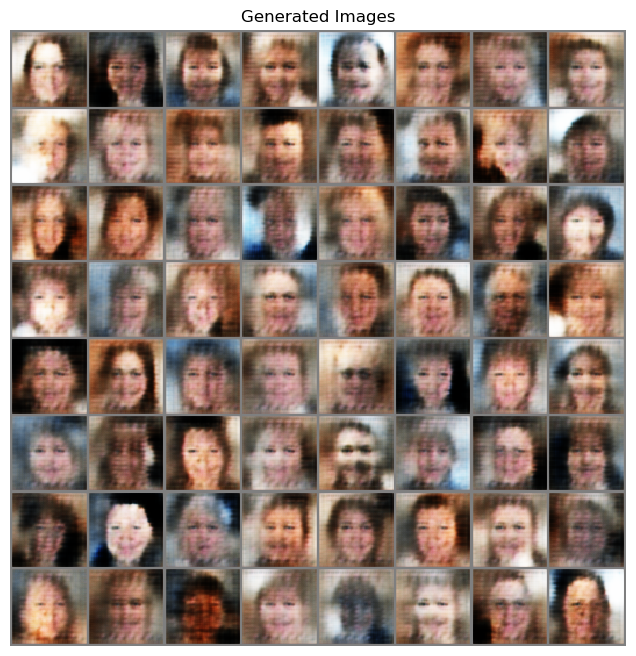

Epoch 4
[100/1094]  loss_diff=0.2781 loss_ediff=0.0129 loss_vae=0.0529 loss_d=0.0009 loss_d_eg=0.0381 loss=0.3821
[200/1094]  loss_diff=0.2808 loss_ediff=0.0135 loss_vae=0.0543 loss_d=0.0009 loss_d_eg=0.0376 loss=0.3862
[300/1094]  loss_diff=0.2780 loss_ediff=0.0128 loss_vae=0.0525 loss_d=0.0006 loss_d_eg=0.0411 loss=0.3843
[400/1094]  loss_diff=0.2738 loss_ediff=0.0124 loss_vae=0.0569 loss_d=0.0010 loss_d_eg=0.0386 loss=0.3816
[500/1094]  loss_diff=0.2651 loss_ediff=0.0129 loss_vae=0.0615 loss_d=0.0008 loss_d_eg=0.0402 loss=0.3796
[600/1094]  loss_diff=0.2666 loss_ediff=0.0129 loss_vae=0.0559 loss_d=0.0008 loss_d_eg=0.0410 loss=0.3764
[700/1094]  loss_diff=0.2752 loss_ediff=0.0130 loss_vae=0.0558 loss_d=0.0028 loss_d_eg=0.0365 loss=0.3805
[800/1094]  loss_diff=0.2922 loss_ediff=0.0122 loss_vae=0.0559 loss_d=0.0011 loss_d_eg=0.0373 loss=0.3976
[900/1094]  loss_diff=0.2761 loss_ediff=0.0127 loss_vae=0.0542 loss_d=0.0016 loss_d_eg=0.0377 loss=0.3807
[1000/1094]  loss_diff=0.2733 loss_edi

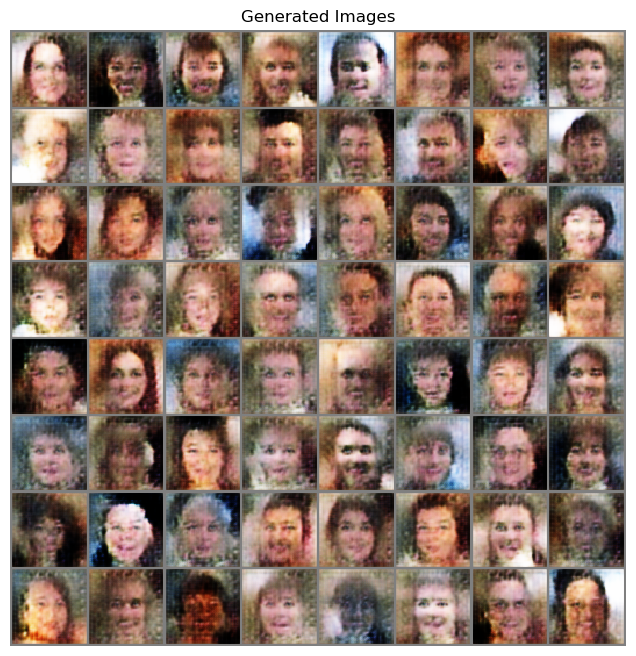

Epoch 5
[100/1094]  loss_diff=0.2683 loss_ediff=0.0126 loss_vae=0.0556 loss_d=0.0025 loss_d_eg=0.0309 loss=0.3674
[200/1094]  loss_diff=0.2794 loss_ediff=0.0124 loss_vae=0.0607 loss_d=0.0010 loss_d_eg=0.0398 loss=0.3922
[300/1094]  loss_diff=0.2745 loss_ediff=0.0129 loss_vae=0.0515 loss_d=0.0024 loss_d_eg=0.0323 loss=0.3712
[400/1094]  loss_diff=0.2918 loss_ediff=0.0134 loss_vae=0.0548 loss_d=0.0031 loss_d_eg=0.0327 loss=0.3926
[500/1094]  loss_diff=0.2735 loss_ediff=0.0118 loss_vae=0.0559 loss_d=0.0024 loss_d_eg=0.0339 loss=0.3750
[600/1094]  loss_diff=0.2779 loss_ediff=0.0128 loss_vae=0.0545 loss_d=0.0030 loss_d_eg=0.0303 loss=0.3754
[700/1094]  loss_diff=0.2731 loss_ediff=0.0129 loss_vae=0.0523 loss_d=0.0024 loss_d_eg=0.0305 loss=0.3689
[800/1094]  loss_diff=0.2769 loss_ediff=0.0119 loss_vae=0.0563 loss_d=0.0022 loss_d_eg=0.0352 loss=0.3803
[900/1094]  loss_diff=0.2900 loss_ediff=0.0117 loss_vae=0.0556 loss_d=0.0014 loss_d_eg=0.0410 loss=0.3983
[1000/1094]  loss_diff=0.2790 loss_edi

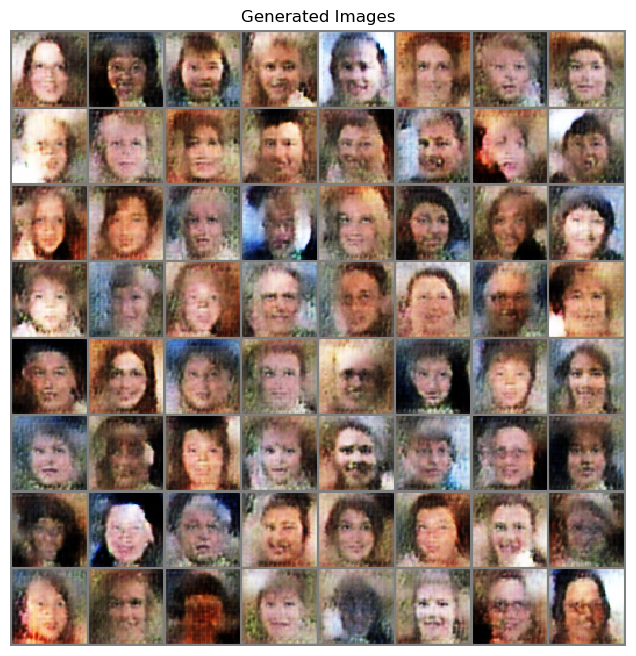

Epoch 6
[100/1094]  loss_diff=0.2793 loss_ediff=0.0123 loss_vae=0.0509 loss_d=0.0030 loss_d_eg=0.0328 loss=0.3753
[200/1094]  loss_diff=0.2812 loss_ediff=0.0122 loss_vae=0.0562 loss_d=0.0026 loss_d_eg=0.0329 loss=0.3825
[300/1094]  loss_diff=0.2883 loss_ediff=0.0124 loss_vae=0.0559 loss_d=0.0025 loss_d_eg=0.0351 loss=0.3916
[400/1094]  loss_diff=0.2751 loss_ediff=0.0129 loss_vae=0.0544 loss_d=0.0034 loss_d_eg=0.0304 loss=0.3727
[500/1094]  loss_diff=0.2802 loss_ediff=0.0115 loss_vae=0.0571 loss_d=0.0017 loss_d_eg=0.0342 loss=0.3831
[600/1094]  loss_diff=0.2829 loss_ediff=0.0122 loss_vae=0.0486 loss_d=0.0041 loss_d_eg=0.0276 loss=0.3714
[700/1094]  loss_diff=0.2781 loss_ediff=0.0114 loss_vae=0.0550 loss_d=0.0019 loss_d_eg=0.0334 loss=0.3779
[800/1094]  loss_diff=0.2870 loss_ediff=0.0111 loss_vae=0.0525 loss_d=0.0020 loss_d_eg=0.0352 loss=0.3858
[900/1094]  loss_diff=0.2742 loss_ediff=0.0111 loss_vae=0.0583 loss_d=0.0021 loss_d_eg=0.0330 loss=0.3766
[1000/1094]  loss_diff=0.2824 loss_edi

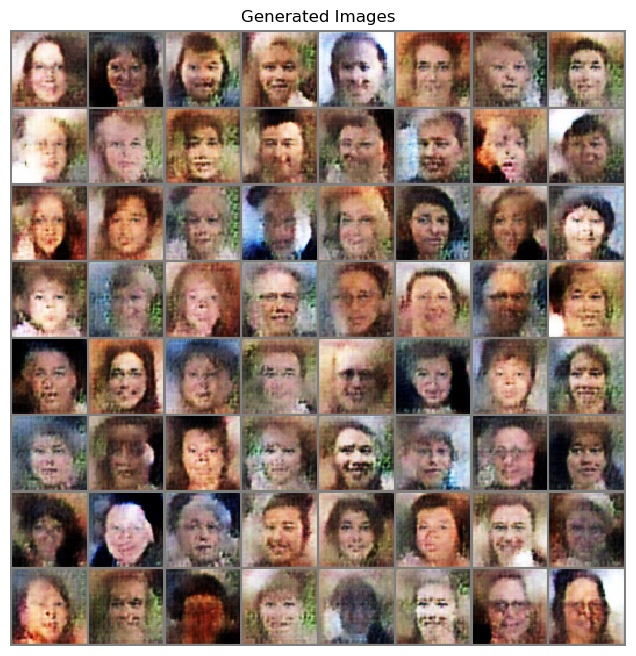

Epoch 7
[100/1094]  loss_diff=0.2590 loss_ediff=0.0113 loss_vae=0.0513 loss_d=0.0031 loss_d_eg=0.0240 loss=0.3457
[200/1094]  loss_diff=0.2824 loss_ediff=0.0111 loss_vae=0.0495 loss_d=0.0022 loss_d_eg=0.0337 loss=0.3767
[300/1094]  loss_diff=0.2918 loss_ediff=0.0119 loss_vae=0.0549 loss_d=0.0030 loss_d_eg=0.0298 loss=0.3884
[400/1094]  loss_diff=0.2758 loss_ediff=0.0117 loss_vae=0.0508 loss_d=0.0024 loss_d_eg=0.0303 loss=0.3686
[500/1094]  loss_diff=0.2822 loss_ediff=0.0120 loss_vae=0.0580 loss_d=0.0030 loss_d_eg=0.0290 loss=0.3812
[600/1094]  loss_diff=0.2877 loss_ediff=0.0116 loss_vae=0.0565 loss_d=0.0026 loss_d_eg=0.0296 loss=0.3855
[700/1094]  loss_diff=0.2738 loss_ediff=0.0112 loss_vae=0.0522 loss_d=0.0025 loss_d_eg=0.0306 loss=0.3679
[800/1094]  loss_diff=0.2664 loss_ediff=0.0122 loss_vae=0.0506 loss_d=0.0040 loss_d_eg=0.0277 loss=0.3570
[900/1094]  loss_diff=0.2873 loss_ediff=0.0117 loss_vae=0.0552 loss_d=0.0031 loss_d_eg=0.0314 loss=0.3856
[1000/1094]  loss_diff=0.2803 loss_edi

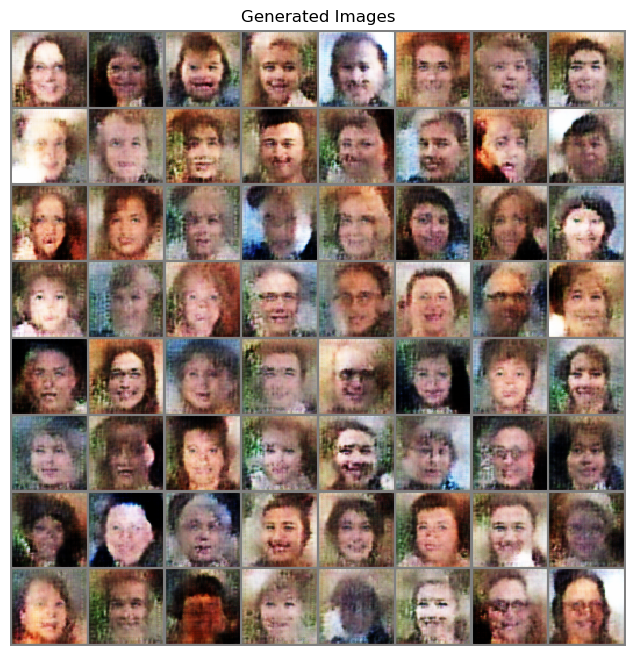

Epoch 8
[100/1094]  loss_diff=0.2755 loss_ediff=0.0114 loss_vae=0.0612 loss_d=0.0031 loss_d_eg=0.0274 loss=0.3754
[200/1094]  loss_diff=0.2845 loss_ediff=0.0109 loss_vae=0.0591 loss_d=0.0028 loss_d_eg=0.0338 loss=0.3882
[300/1094]  loss_diff=0.2760 loss_ediff=0.0118 loss_vae=0.0603 loss_d=0.0014 loss_d_eg=0.0346 loss=0.3827
[400/1094]  loss_diff=0.2767 loss_ediff=0.0113 loss_vae=0.0542 loss_d=0.0044 loss_d_eg=0.0270 loss=0.3692
[500/1094]  loss_diff=0.2808 loss_ediff=0.0115 loss_vae=0.0607 loss_d=0.0035 loss_d_eg=0.0254 loss=0.3784
[600/1094]  loss_diff=0.2792 loss_ediff=0.0111 loss_vae=0.0545 loss_d=0.0026 loss_d_eg=0.0290 loss=0.3739
[700/1094]  loss_diff=0.2867 loss_ediff=0.0114 loss_vae=0.0536 loss_d=0.0030 loss_d_eg=0.0297 loss=0.3813
[800/1094]  loss_diff=0.2826 loss_ediff=0.0108 loss_vae=0.0567 loss_d=0.0019 loss_d_eg=0.0336 loss=0.3837
[900/1094]  loss_diff=0.2822 loss_ediff=0.0110 loss_vae=0.0596 loss_d=0.0019 loss_d_eg=0.0318 loss=0.3846
[1000/1094]  loss_diff=0.2746 loss_edi

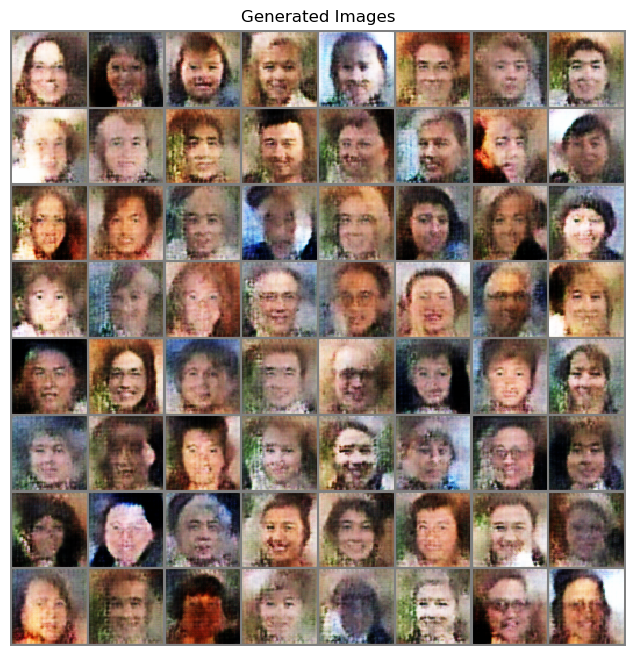

Epoch 9
[100/1094]  loss_diff=0.2818 loss_ediff=0.0114 loss_vae=0.0493 loss_d=0.0034 loss_d_eg=0.0314 loss=0.3739
[200/1094]  loss_diff=0.2766 loss_ediff=0.0110 loss_vae=0.0588 loss_d=0.0029 loss_d_eg=0.0317 loss=0.3781
[300/1094]  loss_diff=0.2726 loss_ediff=0.0104 loss_vae=0.0508 loss_d=0.0026 loss_d_eg=0.0289 loss=0.3627
[400/1094]  loss_diff=0.2955 loss_ediff=0.0113 loss_vae=0.0511 loss_d=0.0019 loss_d_eg=0.0360 loss=0.3938
[500/1094]  loss_diff=0.2703 loss_ediff=0.0107 loss_vae=0.0508 loss_d=0.0025 loss_d_eg=0.0272 loss=0.3590
[600/1094]  loss_diff=0.2855 loss_ediff=0.0109 loss_vae=0.0539 loss_d=0.0031 loss_d_eg=0.0320 loss=0.3823
[700/1094]  loss_diff=0.2778 loss_ediff=0.0111 loss_vae=0.0571 loss_d=0.0034 loss_d_eg=0.0301 loss=0.3761
[800/1094]  loss_diff=0.2823 loss_ediff=0.0116 loss_vae=0.0498 loss_d=0.0029 loss_d_eg=0.0293 loss=0.3731
[900/1094]  loss_diff=0.2680 loss_ediff=0.0110 loss_vae=0.0546 loss_d=0.0033 loss_d_eg=0.0269 loss=0.3605
[1000/1094]  loss_diff=0.2755 loss_edi

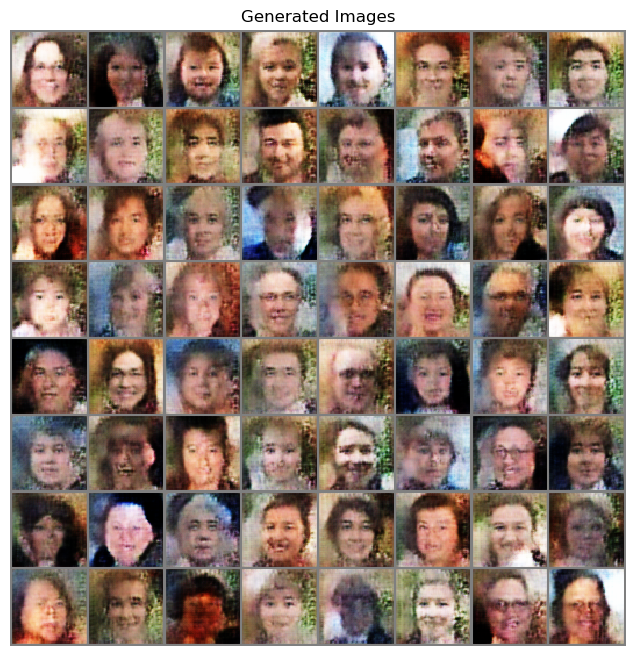

Epoch 10
[100/1094]  loss_diff=0.2709 loss_ediff=0.0108 loss_vae=0.0546 loss_d=0.0048 loss_d_eg=0.0273 loss=0.3635
[200/1094]  loss_diff=0.2812 loss_ediff=0.0115 loss_vae=0.0592 loss_d=0.0025 loss_d_eg=0.0314 loss=0.3834
[300/1094]  loss_diff=0.2850 loss_ediff=0.0113 loss_vae=0.0537 loss_d=0.0030 loss_d_eg=0.0294 loss=0.3795
[400/1094]  loss_diff=0.2795 loss_ediff=0.0117 loss_vae=0.0497 loss_d=0.0015 loss_d_eg=0.0313 loss=0.3723
[500/1094]  loss_diff=0.2790 loss_ediff=0.0106 loss_vae=0.0514 loss_d=0.0025 loss_d_eg=0.0358 loss=0.3768
[600/1094]  loss_diff=0.2789 loss_ediff=0.0105 loss_vae=0.0538 loss_d=0.0030 loss_d_eg=0.0313 loss=0.3745
[700/1094]  loss_diff=0.2745 loss_ediff=0.0110 loss_vae=0.0596 loss_d=0.0032 loss_d_eg=0.0349 loss=0.3799
[800/1094]  loss_diff=0.2860 loss_ediff=0.0109 loss_vae=0.0546 loss_d=0.0037 loss_d_eg=0.0283 loss=0.3799
[900/1094]  loss_diff=0.2698 loss_ediff=0.0109 loss_vae=0.0530 loss_d=0.0027 loss_d_eg=0.0287 loss=0.3624
[1000/1094]  loss_diff=0.2853 loss_ed

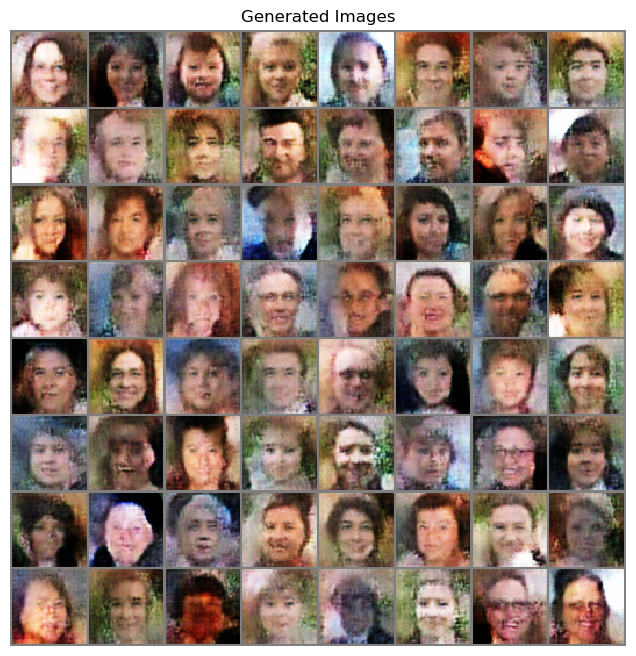

In [39]:
def weights_init(m):
    classname = m.__class__.__name__
    if 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.normal_(m.bias.data, 0.0, 0.02)
    elif 'Linear' in classname:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.1)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.1)
    else:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.02)


def train_epoch(dataloader, net_e, net_g, net_d, loss_fn, optimizer_e, optimizer_g, optimizer_d):
    for batch, x in enumerate(dataloader, 0):
        net_e.zero_grad()
        net_g.zero_grad()
        net_d.zero_grad()
        real = x.to(device)

        encoded = net_e(real)
        fake = net_g(encoded)
        encoded_fake = net_e(fake)

        # loss between real and fake
        loss_diff = 2.0*torch.mean((fake-real)**2)**0.5
        loss_encoded_diff = 0.1*torch.mean((encoded_fake-encoded)**2)**0.5

        # KL divergence loss for VAE
        encoded_mean = torch.mean(encoded, axis=0)
        encoded_cov = torch.cov(encoded.T)
        p1 = torch.distributions.multivariate_normal.MultivariateNormal(
            encoded_mean, encoded_cov)
        p2 = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros_like(encoded_mean, device=device),
            torch.eye(LATENT, device=device))
        loss_vae = 0.01 * torch.distributions.kl_divergence(p1, p2)

        # discriminator - tell apart real and generated
        k_loss_d = 0.01
        label = torch.rand((real.size(0),), device=device) < 0.5
        label = label.float()
        img1 = fake + (real-fake) * label[:, None, None, None]
        img2 = real + (fake-real) * label[:, None, None, None]
        imgs = torch.cat([img1, img2], axis=1)
        guess = net_d(imgs)
        loss_d = k_loss_d*loss_fn(guess.view(-1), label)
        loss_d_eg = k_loss_d*loss_fn(1.0-guess.view(-1), label)

        # train discriminator
        net_d.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizer_d.step()

        # train encoder/generator
        net_e.zero_grad()
        net_g.zero_grad()
        loss = loss_diff + loss_vae + loss_encoded_diff + loss_d_eg
        loss.backward()
        optimizer_e.step()
        optimizer_g.step()

        # output stats
        if (batch+1) % 100 == 0:
            print('[%d/%d]  loss_diff=%.4f loss_ediff=%.4f loss_vae=%.4f loss_d=%.4f loss_d_eg=%.4f loss=%.4f'
                  % (batch+1, len(dataloader),
                     loss_diff.item(), loss_encoded_diff.item(),
                     loss_vae.item(),
                     loss_d.item(), loss_d_eg.item(),
                     loss.item()))


def count_weights(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# load data
dataloader = load_data(FFHQDataset())

# creat models
net_e = Encoder().to(device)
print("Encoder", count_weights(net_e))
print(net_e)

net_g = Generator().to(device)
print("Generator", count_weights(net_g))
print(net_g)

net_d = Discriminator().to(device)
print("Discriminator", count_weights(net_d))
print(net_d)

try:
    net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
    net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
    net_d.load_state_dict(torch.load(MODEL_D_PATH, map_location=device))
    print("Model loaded from file.")
except BaseException as e:
    net_e.apply(weights_init)
    net_g.apply(weights_init)
    net_d.apply(weights_init)
    print("Model weights initialized.")

# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer_e = torch.optim.Adam(net_e.parameters(),
                                lr=0.0001, betas=(0.5, 0.999))
optimizer_g = torch.optim.Adam(net_g.parameters(),
                                lr=0.0001, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(net_d.parameters(),
                                lr=0.00005, betas=(0.5, 0.999))

# train with progress
fixed_noise = torch.randn(64, LATENT, device=device)
for epoch in range(1, 10+1):
    # train
    print("Epoch", epoch)
    train_epoch(dataloader, net_e, net_g, net_d, loss_fn, optimizer_e, optimizer_g, optimizer_d)
    # plot
    if epoch % 1 == 0:
        generated = net_g(fixed_noise)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(vutils.make_grid(
            generated,
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                    interpolation='nearest')
        plt.show() # on ipynb

# export weights

torch.save(net_e.state_dict(), MODEL_E_PATH)
torch.save(net_g.state_dict(), MODEL_G_PATH)
torch.save(net_d.state_dict(), MODEL_D_PATH)


Shape of x: torch.Size([64, 3, 64, 64])
Model loaded from file.


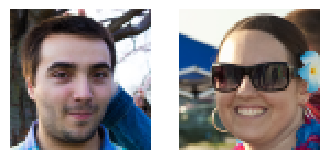

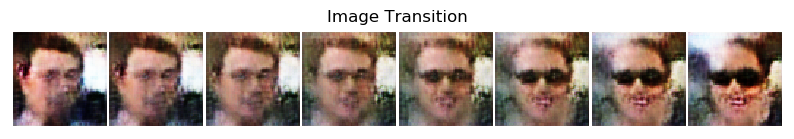

In [91]:
# load data
dataloader = load_data(FFHQDataset())

# creat models
net_e = Encoder().to(device)
net_g = Generator().to(device)

net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
print("Model loaded from file.")

for batch in dataloader:
    img1 = batch[0:1]
    img2 = batch[1:2]
    break

from PIL import Image
# img1 = torch.tensor([np.array(Image.open("/home/harry7557558/me.png").convert("RGB").resize((64,64)), dtype=np.float32)/255.0]).permute(0, 3, 1, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 10))
ax1.imshow(img1[0].permute(1, 2, 0))
ax2.imshow(img2[0].permute(1, 2, 0))
ax1.axis("off")
ax2.axis("off")
plt.show()

n = 8
enc1 = net_e(img1.to(device))
enc2 = net_e(img2.to(device))
t = torch.linspace(0, 1, n, device=device)
enc = enc1 + (enc2-enc1) * t[:, None]
img = net_g(enc)

plt.figure(figsize=(10, 30))
plt.axis("off")
plt.title("Image Transition")
plt.imshow(np.transpose(vutils.make_grid(
    img,
    padding=2, pad_value=1, normalize=True).cpu(), (1, 2, 0)),
            interpolation='nearest')
plt.show() # on ipynb


In [95]:
param_i = 0
layers = {}
prev_class = None
prev_path = None
for layer in net_g.main:
    if layer.__class__.__name__ == "Linear":
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
    elif layer.__class__.__name__ in ['Conv2d', "ConvTranspose2d"]:
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
    elif layer.__class__.__name__ == "BatchNorm2d":
        assert len(layers[prev_path].shape) == 4
        mu = layer.running_mean.cpu()
        var = layer.running_var.cpu()
        invstdev = 1.0 / (var + 1e-5)**0.5
        data = list(layer.parameters())
        gamma, beta = data[0].data.cpu(), data[1].data.cpu()
        a = gamma * invstdev
        b = beta - mu * gamma * invstdev
        a, b = a.numpy(), b.numpy()
        if prev_class == 'ConvTranspose2d':
            layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis]
        elif prev_class == 'Conv2d':
            layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis, np.newaxis]
        # print(a.shape, b.shape, layers[prev_path].shape)
        shape = '_'.join(map(str, b.shape))
        path = EXPORT_PATH+"/b{:02d}_{}.bin".format(param_i, shape)
        layers[path] = b
    else:
        print(layer.__class__.__name__)
        prev_path = None
    prev_class = layer.__class__.__name__

for path, data in layers.items():
    data.astype(np.float32).tofile(path)

LeakyReLU
Unflatten
LeakyReLU
LeakyReLU
LeakyReLU
LeakyReLU
LeakyReLU
LeakyReLU
LeakyReLU
LeakyReLU
LeakyReLU
LeakyReLU
Sigmoid
